In [5]:
# Initial imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from numpy.random import seed
seed(1)
from tensorflow import random
random.set_seed(2)

  # Importing required Keras modules
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
%matplotlib inline

In [32]:
#set path to Features CSV and read in CSV
tsla_df = pd.read_pickle('Resources/tsla_features_df.pickle')
tsla_df.head()

,tsla Close,tsla Volume,Call Volume,Put Volume,Total Option Volume,Percent of Puts,Put signals,Percent of calls,Call signals,bollinger_mid_band,...,rvol SD,rvol signal,Option rVol,Option rVol SD,Option rVol signal,daily returns,sent_by_sentence_score,sentiment neg,sentiment pos,sentiment score
2019-08-05,228.48,6526882,132451.0,170466.0,302917.0,0.218881,False,0.437252,False,243.386915,...,1.186054,0.0,1.854970,1.186054,0.0,-0.024750,0.0000,0,0,0
2019-08-06,230.63,5256223,99069.0,177211.0,276280.0,0.328703,False,0.358582,False,243.399415,...,1.188592,0.0,1.633764,1.188592,0.0,0.009410,0.0000,0,0,0
2019-08-07,233.47,4574805,133941.0,145802.0,279743.0,0.286719,False,0.478800,False,243.569915,...,1.186841,0.0,1.601279,1.186841,0.0,0.012314,0.0000,0,0,0
2019-08-08,238.29,5027207,30924.0,47015.0,77939.0,0.049931,False,0.396772,False,243.538415,...,1.175442,0.0,0.462833,1.175442,0.0,0.020645,0.1745,0,1,1
2019-08-09,235.00,3678950,65529.0,62168.0,127697.0,0.120099,False,0.513160,False,243.358415,...,1.164937,0.0,0.750311,1.164937,0.0,-0.013807,0.0000,0,0,0


In [33]:
#Create new trading signals Df, Set index as datetime object and drop extraneous columns
trading_signals_df = pd.DataFrame()

In [37]:
#add daily change rates to increase the staionarity of dataset
trading_signals_df['volume delta'] = tsla_df['tsla Volume'].dropna().pct_change()
trading_signals_df['bb std delta'] = tsla_df['bollinger_std'].dropna().pct_change()
trading_signals_df['rvol delta'] = tsla_df['rvol'].dropna().pct_change()
trading_signals_df['option rvol delta'] = tsla_df['Option rVol'].dropna().pct_change()
trading_signals_df['sentiment'] = tsla_df['sent_by_sentence_score'].fillna(0).pct_change()

#add daily returns as target
trading_signals_df['daily returns'] = tsla_df['daily returns'].dropna()

trading_signals_df= trading_signals_df.fillna(value = 0)
trading_signals_df= trading_signals_df.replace([np.inf, -np.inf], 0.0)
trading_signals_df.head()

,volume delta,bb std delta,rvol delta,option rvol delta,sentiment,daily returns
2019-08-05,0.000000,0.000000,0.000000,0.000000,0.0,-0.024750
2019-08-06,-0.194681,-0.001140,-0.192712,-0.119250,0.0,0.009410
2019-08-07,-0.129640,-0.014270,-0.121799,-0.019884,0.0,0.012314
2019-08-08,0.098890,0.001137,0.123354,-0.710960,0.0,0.020645
2019-08-09,-0.268192,0.008675,-0.250867,0.621125,-1.0,-0.013807


In [38]:
 def window_data(window):
    """
    It chunks the data up with a rolling window of Xt - window to predict Xt.
    It returns two numpy arrays of X and y.
    """
    X = []
    y = []
    for i in range(len(trading_signals_df) - window):
        features = trading_signals_df.iloc[i : (i + window), :]
        target = trading_signals_df.iloc[(i + window), -1]
        X.append(features)
        y.append(target)
    
    return np.array(X), np.array(y).reshape(-1, 1)

In [39]:
# Define the window size
window_size = 7

# Create the features (X) and target (y) data using the window_data() function.
X, y = window_data(window_size)



In [40]:
# Manually splitting the data
split = int(0.7 * len(X))

X_train = X[: split]
X_test = X[split:]

y_train = y[: split]
y_test = y[split:]

In [41]:
scalers = {}
for i in range(X_train.shape[1]):
    scalers[i] = MinMaxScaler()
    X_train[:, i, :] = scalers[i].fit_transform(X_train[:, i, :]) 

for i in range(X_test.shape[1]):
    X_test[:, i, :] = scalers[i].transform(X_test[:, i, :])



In [42]:
scaler = MinMaxScaler()
scaler.fit(y)
y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test)

In [43]:
# Define the Transformer model.
model = Sequential()

# Initial model setup
number_units = 7
dropout_fraction = 0.3
inputs = len(trading_signals_df.columns)

# Layer 1
model.add(LSTM(
    units=number_units,
    return_sequences=True,
    input_shape=(X.shape[1], inputs))
    )
model.add(Dropout(dropout_fraction))

# Layer 2
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))

# Layer 3
model.add(LSTM(units=number_units))
model.add(Dropout(dropout_fraction))

# Output layer
model.add(Dense(1, activation = 'linear'))

In [44]:
# Compile the LSTM model
model.compile(optimizer="adam", loss="mean_squared_error")

In [45]:
# Show the model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 7, 7)              392       
_________________________________________________________________
dropout_3 (Dropout)          (None, 7, 7)              0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 7, 7)              420       
_________________________________________________________________
dropout_4 (Dropout)          (None, 7, 7)              0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 7)                 420       
_________________________________________________________________
dropout_5 (Dropout)          (None, 7)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                

In [46]:
 # Train the model
model.fit(X_train, y_train, epochs=100, shuffle=False, verbose=0)

In [47]:
 # Make predictions using the testing data X_test
predicted = model.predict(X_test)

In [48]:
#Recover the original, nonscaled prices
predicted_prices = scaler.inverse_transform(predicted)
real_prices = scaler.inverse_transform(y_test.reshape(-1,1)) 

In [49]:
# Create a DataFrame of Real and Predicted values, shifted by forward window
shift =7
stocks = pd.DataFrame({
    "Actual": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
}, index = trading_signals_df.index[-len(real_prices)-shift:-shift ] )


# Show the DataFrame's head
stocks

,Actual,Predicted
2019-11-12,0.007292,0.003991
2019-11-13,-0.061920,0.004010
2019-11-14,0.009943,0.001378
2019-11-15,-0.021918,0.001658
2019-11-18,0.006445,0.000119
2019-11-19,-0.003051,-0.001038
2019-11-20,0.014604,-0.000828
2019-11-21,0.003643,-0.001394
2019-11-22,-0.009194,-0.002501
2019-11-25,-0.007958,-0.002872


In [50]:
#convert stocks df into positive and negative signals
stocks['Positive Actual signal'] = np.where(stocks['Actual'] > 0, 1, 0)
stocks['Negative Actual signal'] = np.where(stocks['Actual'] < 0, -1, 0)

stocks['Positive Predicted signal'] = np.where(stocks['Predicted'] > 0, 1, 0)
stocks['Negative Predicted signal'] = np.where(stocks['Predicted'] < 0, -1, 0)

#merge to create one column per signal, shifted back to reflect forward projection window
shift = 7
stocks['Actual Signal'] = stocks['Positive Actual signal'] + stocks['Negative Actual signal']
stocks['LSTM Predicted Signal'] = stocks['Positive Predicted signal'] + stocks['Negative Predicted signal']
stocks

,Actual,Predicted,Positive Actual signal,Negative Actual signal,Positive Predicted signal,Negative Predicted signal,Actual Signal,LSTM Predicted Signal
2019-11-12,0.007292,0.003991,1,0,1,0,1,1
2019-11-13,-0.061920,0.004010,0,-1,1,0,-1,1
2019-11-14,0.009943,0.001378,1,0,1,0,1,1
2019-11-15,-0.021918,0.001658,0,-1,1,0,-1,1
2019-11-18,0.006445,0.000119,1,0,1,0,1,1
2019-11-19,-0.003051,-0.001038,0,-1,0,-1,-1,-1
2019-11-20,0.014604,-0.000828,1,0,0,-1,1,-1
2019-11-21,0.003643,-0.001394,1,0,0,-1,1,-1
2019-11-22,-0.009194,-0.002501,0,-1,0,-1,-1,-1
2019-11-25,-0.007958,-0.002872,0,-1,0,-1,-1,-1


In [51]:
stocks['LSTM Predicted Signal'].to_pickle(r'C:\Users\Kiel\Desktop\FINTECH\UCB_fintech_homework\project_2 - local\Resources\TSLA_LSTM_signals_df.pickle')

<AxesSubplot:>

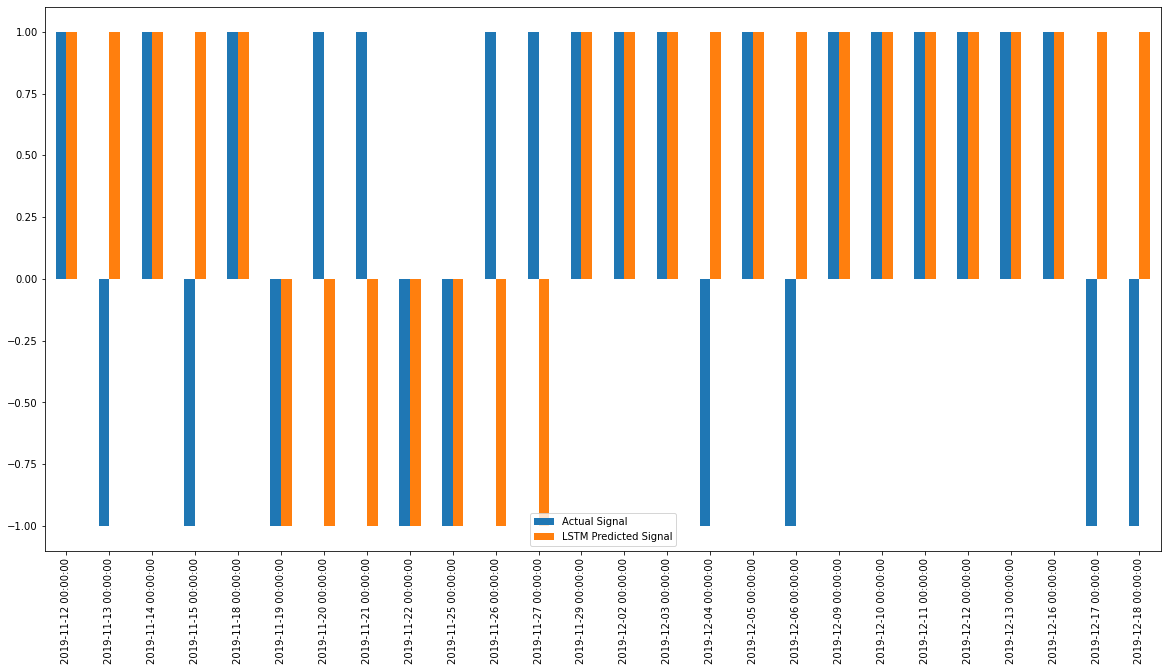

In [53]:
stocks.plot(y = ['Actual Signal', 'LSTM Predicted Signal'], figsize = (20,10), kind = 'bar')

<AxesSubplot:>

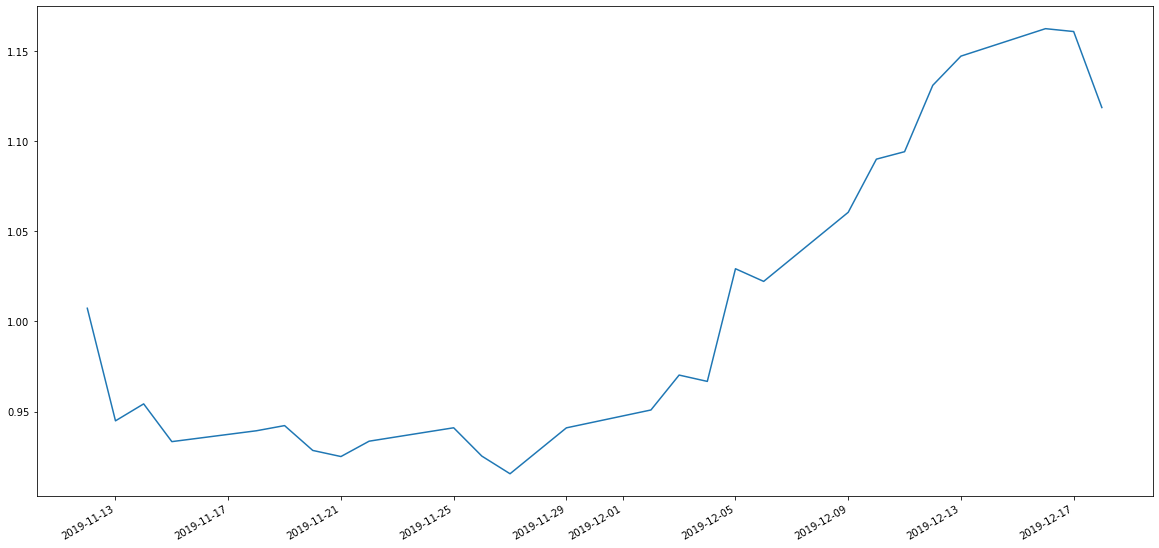

In [54]:
# Calculate cumulative return of model and plot the result
(1 + (stocks['Actual'] * stocks['LSTM Predicted Signal'])).cumprod().plot(figsize = (20,10))

<AxesSubplot:>

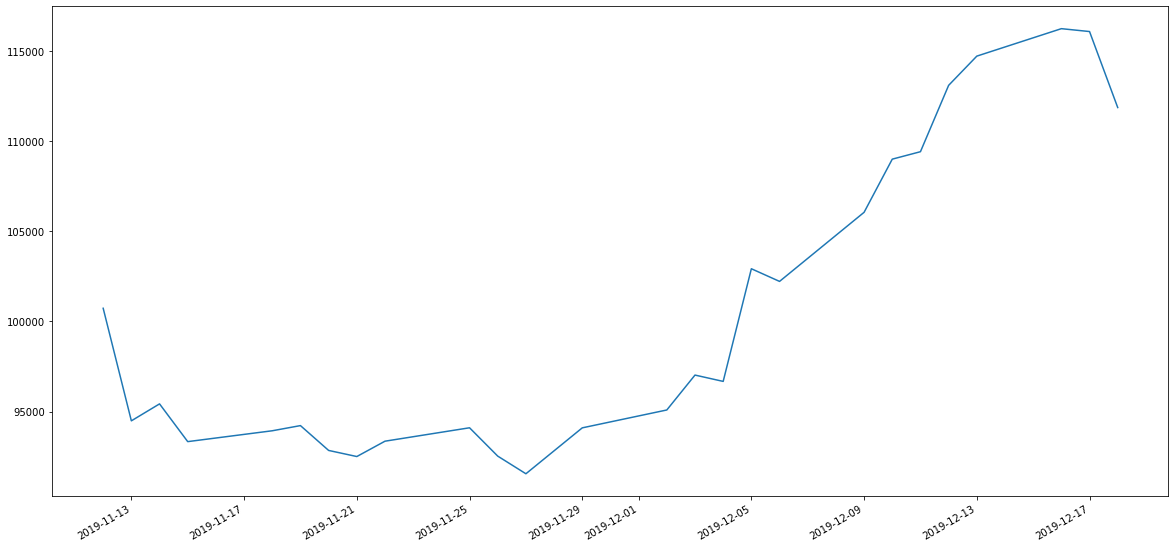

In [55]:
# Set initial capital allocation
initial_capital = 100000

# Plot cumulative return of model in terms of capital
cumulative_return_capital = initial_capital * (1 + (stocks['Actual'] * stocks['LSTM Predicted Signal'])).cumprod()
cumulative_return_capital.plot(figsize = (20,10))